# MONTE CARLO SIMULATION OF STOCK PRICES

In [23]:
'''
import the various dependencies that will allow for this script to run 
as well as creating the class and initial variables we will need
'''
from pandas_datareader import data, wb
import pandas as pd
import datetime
import numpy as np
import math
from scipy import stats
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

style.use('fivethirtyeight')
        
class monte_carlo:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
    '''make two methods within our class, one for a single asset,
    and one for a portfolio of assets.'''     
    def get_asset(self, symbol):
        #Dates
        start = self.start 
        end = self.end 
        
        prices = data.DataReader(symbol, 'yahoo',start, end)['Adj Close']
        returns = prices.pct_change()
        
        self.returns = returns
        self.prices = prices
    
    def get_portfolio(self, symbols, weights):
        start = self.start
        end = self.end
        
        #Get Price Data
        df = web.DataReader(symbols, 'google',start, end)['Close']
        #Percent Change
        returns = df.pct_change()
        returns += 1
        
        #Define dollar amount in each asset
        port_val = returns * weights
        port_val['Portfolio Value'] = port_val.sum(axis=1)
        
        #Portfolio Dollar Values
        prices = port_val['Portfolio Value']
        
        #Portfolio Returns
        returns = port_val['Portfolio Value'].pct_change()
        returns = returns.replace([np.inf, -np.inf], np.nan)
                
        self.returns = returns
        self.prices = prices
        
    '''
    create a basic simulation that only uses the asset’s daily volatility, 
    while the other simulation will be using the concept of Geometric Brownian Motion.
    '''
    def monte_carlo_sim(self, num_simulations, predicted_days):
        returns = self.returns
        prices = self.prices
        
        last_price = prices[-1]
        
        simulation_df = pd.DataFrame()

        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            count = 0
            daily_vol = returns.std()
            
            price_series = []
            
            #Append Start Value
            price = last_price * (1 + np.random.normal(0, daily_vol))
            price_series.append(price)
            
            #Series for Preditcted Days
            for i in range(predicted_days):
                if count == 251:
                    break
                price = price_series[count] * (1 + np.random.normal(0, daily_vol))
                price_series.append(price)
                count += 1
        
            simulation_df[x] = price_series
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days
            
    def brownian_motion(self, num_simulations, predicted_days):
        returns = self.returns
        prices = self.prices

        last_price = prices[-1]

        #Note we are assuming drift here
        simulation_df = pd.DataFrame()
        
        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            
            #Inputs
            count = 0
            avg_daily_ret = returns.mean()
            variance = returns.var()
            
            daily_vol = returns.std()
            daily_drift = avg_daily_ret - (variance/2)
            drift = daily_drift - 0.5 * daily_vol ** 2
            
            #Append Start Value    
            prices = []
            
            shock = drift + daily_vol * np.random.normal()
            last_price * math.exp(shock)
            prices.append(last_price)
            
            for i in range(predicted_days):
                if count == 251:
                    break
                shock = drift + daily_vol * np.random.normal()
                price = prices[count] * math.exp(shock)
                prices.append(price)
                
        
                count += 1
            simulation_df[x] = prices
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days
            
    # create a line graph and histogram to visualize our data with Matplotlib.
    def line_graph(self):
        prices = self.prices
        predicted_days = self.predicted_days
        simulation_df = self.simulation_df
        
        last_price = prices[-1]
        fig = plt.figure()
        style.use('bmh')
        
        title = "Monte Carlo Simulation: " + str(predicted_days) + " Days"
        plt.plot(simulation_df)
        fig.suptitle(title,fontsize=18, fontweight='bold')
        plt.xlabel('Day')
        plt.ylabel('Price ($USD)')
        plt.grid(True,color='grey')
        plt.axhline(y=last_price, color='r', linestyle='-')
        plt.show()
        

        #
    def histogram(self):
        simulation_df = self.simulation_df
        
        ser = simulation_df.iloc[-1, :]
        x = ser
        mu = ser.mean()
        sigma = ser.std()
        
        num_bins = 20
        # the histogram of the data
        n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='blue', alpha=0.5)
         
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
        plt.show()
        
    def VaR(self):
        
        '''
        we can actually calculate our theoretical Value at Risk with the given portfolio and simulation outputs. 
        The Value at Risk is simply the difference between the current price and specified price at a given confidence 
        interval.
        '''
        simulation_df = self.simulation_df
        prices = self.prices

        last_price = prices[-1]
        
        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int)  
        var =  np.percentile(price_array, 1)
        
        val_at_risk = last_price - var
        print("Value at Risk: ", val_at_risk)
        
        #Histogram
        fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
        plt.plot(price_array,fit,'-o')
        plt.hist(price_array,density=True)
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
        plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: ' + str(round(var, 2)))
        plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: ' + str(round(last_price, 2)))
        plt.legend(loc="upper right")
        plt.show()
        
    # analyze the outputted simulations.  this can be done in a variety of ways.
    
    def key_stats(self):
        simulation_df = self.simulation_df

        print('#------------------Simulation Stats------------------#')
        count = 1
        for column in simulation_df:
            print("Simulation", count, "Mean Price: ", simulation_df[column].mean())
            print("Simulation", count, "Median Price: ", simulation_df[column].median())
            count += 1
        
        print('\n')
        
        print('#----------------------Last Price Stats--------------------#')
        print("Mean Price: ", np.mean(simulation_df.iloc[-1,:]))
        print("Maximum Price: ",np.max(simulation_df.iloc[-1,:]))
        print("Minimum Price: ", np.min(simulation_df.iloc[-1,:]))
        print("Standard Deviation: ",np.std(simulation_df.iloc[-1,:]))

        print('\n')
       
        print('#----------------------Descriptive Stats-------------------#')
        price_array = simulation_df.iloc[-1, :]
        print(price_array.describe())

        print('\n')
               
        print('#--------------Annual Expected Returns for Trials-----------#')
        count = 1
        future_returns = simulation_df.pct_change()
        for column in future_returns:
            print("Simulation", count, "Annual Expected Return", "{0:.2f}%".format((future_returns[column].mean() * 252) * 100))
            print("Simulation", count, "Total Return", "{0:.2f}%".format((future_returns[column].iloc[1] / future_returns[column].iloc[-1] - 1) * 100))
            count += 1     

        print('\n')
                         
        #Create Column For Average Daily Price Across All Trials
        simulation_df['Average'] = simulation_df.mean(axis=1)
        ser = simulation_df['Average']
        
        print('#----------------------Percentiles--------------------------------#')
        percentile_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
        for per in percentile_list:
            print("{}th Percentile: ".format(per), np.percentile(price_array, per))
        
        print('\n')
        
        print('#-----------------Calculate Probabilities-------------------------#')
       # print("Probability price is between 30 and 40: ",  "{0:.2f}%".format((float(len(price_array[(price_array&gt; 30) &amp; (price_array&lt;- 40)])) / float(len(price_array)) * 100))) 
       # print("Probability price is &gt; 45: ", "{0:.2f}%".format((float(len(price_array[price_array &gt; 45])) / float(len(price_array)))* 100))

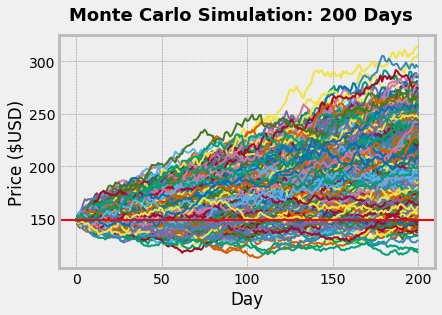

Value at Risk:  7.324007554148579


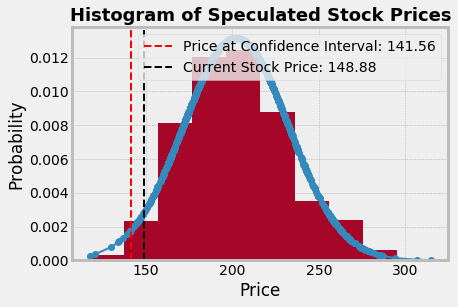

#------------------Simulation Stats------------------#
Simulation 1 Mean Price:  187.787630911004
Simulation 1 Median Price:  174.55756960135346
Simulation 2 Mean Price:  150.05218449241295
Simulation 2 Median Price:  149.23675111045796
Simulation 3 Mean Price:  188.21158701897488
Simulation 3 Median Price:  187.01712351646935
Simulation 4 Mean Price:  173.01074146055507
Simulation 4 Median Price:  162.41069050732224
Simulation 5 Mean Price:  187.9932498558137
Simulation 5 Median Price:  185.71054313174088
Simulation 6 Mean Price:  190.6352422728988
Simulation 6 Median Price:  190.5069680652041
Simulation 7 Mean Price:  182.02619170845648
Simulation 7 Median Price:  180.05011143891096
Simulation 8 Mean Price:  174.81774805995576
Simulation 8 Median Price:  178.99642941612763
Simulation 9 Mean Price:  173.20731852595253
Simulation 9 Median Price:  174.33159314702218
Simulation 10 Mean Price:  185.2941774737499
Simulation 10 Median Price:  188.26402300233931
Simulation 11 Mean Price:  19

Simulation 212 Median Price:  196.6676497019831
Simulation 213 Mean Price:  191.32836412624084
Simulation 213 Median Price:  188.0777476991837
Simulation 214 Mean Price:  177.6926074200844
Simulation 214 Median Price:  179.8577127623676
Simulation 215 Mean Price:  169.82798783737272
Simulation 215 Median Price:  174.85934825506675
Simulation 216 Mean Price:  168.74204840535256
Simulation 216 Median Price:  173.81847585085842
Simulation 217 Mean Price:  173.34298391384803
Simulation 217 Median Price:  173.89653147432253
Simulation 218 Mean Price:  174.41050257116444
Simulation 218 Median Price:  163.36232011082768
Simulation 219 Mean Price:  190.92733924504572
Simulation 219 Median Price:  192.09068544558914
Simulation 220 Mean Price:  196.91321806754848
Simulation 220 Median Price:  195.67814194814926
Simulation 221 Mean Price:  174.45041557847478
Simulation 221 Median Price:  170.03722394667832
Simulation 222 Mean Price:  154.7597346443675
Simulation 222 Median Price:  157.01462477687

Simulation 384 Median Price:  150.84590715829356
Simulation 385 Mean Price:  171.09173915249997
Simulation 385 Median Price:  167.59245381286343
Simulation 386 Mean Price:  202.02277688271704
Simulation 386 Median Price:  203.74571670520686
Simulation 387 Mean Price:  159.19294969655525
Simulation 387 Median Price:  153.70706920544654
Simulation 388 Mean Price:  184.90832954830307
Simulation 388 Median Price:  185.18089704072074
Simulation 389 Mean Price:  178.0164119052067
Simulation 389 Median Price:  174.15192429493194
Simulation 390 Mean Price:  163.56511577944153
Simulation 390 Median Price:  166.36658734425535
Simulation 391 Mean Price:  175.9182901235624
Simulation 391 Median Price:  180.6447072609352
Simulation 392 Mean Price:  191.59349220500712
Simulation 392 Median Price:  194.31762317395123
Simulation 393 Mean Price:  154.73509618937885
Simulation 393 Median Price:  151.055254550341
Simulation 394 Mean Price:  199.3795215235815
Simulation 394 Median Price:  199.984934415118

Simulation 575 Mean Price:  159.4010074548618
Simulation 575 Median Price:  158.84260708751444
Simulation 576 Mean Price:  179.48223072572452
Simulation 576 Median Price:  180.34307958106766
Simulation 577 Mean Price:  147.8644688885209
Simulation 577 Median Price:  147.8552076287732
Simulation 578 Mean Price:  153.912111646141
Simulation 578 Median Price:  153.13551369049804
Simulation 579 Mean Price:  158.92587612069778
Simulation 579 Median Price:  156.77044201850964
Simulation 580 Mean Price:  216.73080870331174
Simulation 580 Median Price:  212.04775560120925
Simulation 581 Mean Price:  191.3016622567674
Simulation 581 Median Price:  196.47784093154468
Simulation 582 Mean Price:  180.7547565947366
Simulation 582 Median Price:  179.46042165323672
Simulation 583 Mean Price:  174.05384940723687
Simulation 583 Median Price:  172.91319581487585
Simulation 584 Mean Price:  184.81052847980638
Simulation 584 Median Price:  183.9793489344288
Simulation 585 Mean Price:  163.79955948912965
S

Simulation 764 Median Price:  184.47966302600398
Simulation 765 Mean Price:  166.60911958405907
Simulation 765 Median Price:  167.9554797381745
Simulation 766 Mean Price:  177.45816754603152
Simulation 766 Median Price:  179.3859698420806
Simulation 767 Mean Price:  174.36947961519468
Simulation 767 Median Price:  174.83686993689244
Simulation 768 Mean Price:  175.5178953473313
Simulation 768 Median Price:  174.73631058140214
Simulation 769 Mean Price:  168.91770086596486
Simulation 769 Median Price:  168.6904140692296
Simulation 770 Mean Price:  188.8287253537094
Simulation 770 Median Price:  186.07146365992756
Simulation 771 Mean Price:  178.3348304892344
Simulation 771 Median Price:  177.28921382371158
Simulation 772 Mean Price:  203.14133578423008
Simulation 772 Median Price:  208.25217825627172
Simulation 773 Mean Price:  152.70140686633727
Simulation 773 Median Price:  143.8204345654325
Simulation 774 Mean Price:  169.24525197874001
Simulation 774 Median Price:  170.5827281545390

Simulation 912 Median Price:  215.27116068010602
Simulation 913 Mean Price:  176.921314959587
Simulation 913 Median Price:  176.22393718880323
Simulation 914 Mean Price:  170.2690321950356
Simulation 914 Median Price:  161.46322916139385
Simulation 915 Mean Price:  199.9337936685019
Simulation 915 Median Price:  186.61996331899317
Simulation 916 Mean Price:  199.2140594762997
Simulation 916 Median Price:  204.14703067606123
Simulation 917 Mean Price:  176.29826697715143
Simulation 917 Median Price:  183.67346508238737
Simulation 918 Mean Price:  171.66645108289134
Simulation 918 Median Price:  165.7649415769963
Simulation 919 Mean Price:  174.88566580008722
Simulation 919 Median Price:  171.4681168175976
Simulation 920 Mean Price:  178.62964659115448
Simulation 920 Median Price:  169.99041898513227
Simulation 921 Mean Price:  137.2244246996978
Simulation 921 Median Price:  132.94829705901043
Simulation 922 Mean Price:  167.7624228720204
Simulation 922 Median Price:  171.99562652169223


Simulation 1 Annual Expected Return 56.54%
Simulation 1 Total Return -441.86%
Simulation 2 Annual Expected Return 17.41%
Simulation 2 Total Return -295.60%
Simulation 3 Annual Expected Return 50.13%
Simulation 3 Total Return -225.26%
Simulation 4 Annual Expected Return 42.13%
Simulation 4 Total Return -141.99%
Simulation 5 Annual Expected Return 37.16%
Simulation 5 Total Return -207.05%
Simulation 6 Annual Expected Return 47.90%
Simulation 6 Total Return -132.48%
Simulation 7 Annual Expected Return 54.40%
Simulation 7 Total Return -155.03%
Simulation 8 Annual Expected Return 43.68%
Simulation 8 Total Return -258.73%
Simulation 9 Annual Expected Return 25.21%
Simulation 9 Total Return -0.83%
Simulation 10 Annual Expected Return 44.34%
Simulation 10 Total Return -38.99%
Simulation 11 Annual Expected Return 41.78%
Simulation 11 Total Return 272.94%
Simulation 12 Annual Expected Return 70.60%
Simulation 12 Total Return -103.04%
Simulation 13 Annual Expected Return 27.96%
Simulation 13 Tota

Simulation 232 Annual Expected Return 34.18%
Simulation 232 Total Return -59.43%
Simulation 233 Annual Expected Return 52.77%
Simulation 233 Total Return 83.27%
Simulation 234 Annual Expected Return 28.05%
Simulation 234 Total Return -107.82%
Simulation 235 Annual Expected Return 35.93%
Simulation 235 Total Return -97.63%
Simulation 236 Annual Expected Return 44.65%
Simulation 236 Total Return 75.07%
Simulation 237 Annual Expected Return 63.88%
Simulation 237 Total Return 66.32%
Simulation 238 Annual Expected Return 30.07%
Simulation 238 Total Return -277.75%
Simulation 239 Annual Expected Return 28.78%
Simulation 239 Total Return 110.76%
Simulation 240 Annual Expected Return 32.98%
Simulation 240 Total Return -147.79%
Simulation 241 Annual Expected Return 18.88%
Simulation 241 Total Return -89.20%
Simulation 242 Annual Expected Return 52.19%
Simulation 242 Total Return 121.85%
Simulation 243 Annual Expected Return 22.62%
Simulation 243 Total Return -17.75%
Simulation 244 Annual Expect

Simulation 473 Annual Expected Return 51.32%
Simulation 473 Total Return -260.44%
Simulation 474 Annual Expected Return 27.22%
Simulation 474 Total Return -110.17%
Simulation 475 Annual Expected Return 35.16%
Simulation 475 Total Return -96.85%
Simulation 476 Annual Expected Return 49.26%
Simulation 476 Total Return 255.33%
Simulation 477 Annual Expected Return 20.31%
Simulation 477 Total Return -281.22%
Simulation 478 Annual Expected Return 14.46%
Simulation 478 Total Return -174.22%
Simulation 479 Annual Expected Return 8.03%
Simulation 479 Total Return -278.52%
Simulation 480 Annual Expected Return 18.80%
Simulation 480 Total Return -317.63%
Simulation 481 Annual Expected Return 47.81%
Simulation 481 Total Return -308.46%
Simulation 482 Annual Expected Return 0.00%
Simulation 482 Total Return -427.78%
Simulation 483 Annual Expected Return 41.89%
Simulation 483 Total Return 889.33%
Simulation 484 Annual Expected Return 63.08%
Simulation 484 Total Return 3872.15%
Simulation 485 Annual

Simulation 739 Annual Expected Return 6.86%
Simulation 739 Total Return -175.48%
Simulation 740 Annual Expected Return 40.69%
Simulation 740 Total Return -215.70%
Simulation 741 Annual Expected Return 39.86%
Simulation 741 Total Return 1670.20%
Simulation 742 Annual Expected Return 15.81%
Simulation 742 Total Return -2.84%
Simulation 743 Annual Expected Return 60.62%
Simulation 743 Total Return -91.79%
Simulation 744 Annual Expected Return 40.13%
Simulation 744 Total Return -63.44%
Simulation 745 Annual Expected Return 35.43%
Simulation 745 Total Return -675.34%
Simulation 746 Annual Expected Return 19.43%
Simulation 746 Total Return -96.74%
Simulation 747 Annual Expected Return 71.45%
Simulation 747 Total Return -10830.22%
Simulation 748 Annual Expected Return 34.48%
Simulation 748 Total Return -4467.82%
Simulation 749 Annual Expected Return 65.67%
Simulation 749 Total Return -97.41%
Simulation 750 Annual Expected Return 41.69%
Simulation 750 Total Return -163.49%
Simulation 751 Annua

#----------------------Percentiles--------------------------------#
5th Percentile:  156.68390837775559
10th Percentile:  164.56260772869754
15th Percentile:  170.7025651117272
20th Percentile:  175.60279007448528
25th Percentile:  180.62488300643554
30th Percentile:  184.66220026635796
35th Percentile:  188.3325051542701
40th Percentile:  192.41031173887313
45th Percentile:  196.3963743717676
50th Percentile:  199.14885441425517
55th Percentile:  203.1174341069801
60th Percentile:  207.68386540958534
65th Percentile:  212.3298954921163
70th Percentile:  217.1103762005902
75th Percentile:  221.2253458285194
80th Percentile:  226.41423646607242
85th Percentile:  233.23254610610374
90th Percentile:  242.15558303552854
95th Percentile:  258.44763990195673


#-----------------Calculate Probabilities-------------------------#


In [25]:
# Finally, to run the script:
if __name__== "__main__":

    start = datetime.datetime(2017, 1, 3)
    end = datetime.datetime(2017, 10, 4)
    
    sim = monte_carlo(start, end)

    #symbols = ['AAPL', 'KO', 'HD', 'PM']
    #weights = [1000,1000,2000,3000]
    
    #sim.get_portfolio(symbols, weights)
    sim.get_asset('AAPL')

    sim.brownian_motion(1000, 200)
    sim.line_graph()
    sim.VaR()
    #sim.key_stats()